### In the name of God
---
### Deep Learning HW2
### Fine-tuning Resnet



**Name:** Danial Ataie

**Std. No.:** 99100455

In [1]:
import torch
import torchvision
from torch.autograd import Variable
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import models
import torchvision.transforms as transforms
from torchvision import datasets
import torch.optim as optim
import matplotlib.pyplot as plt

## Data Preparation

In [2]:
# Define the transformations to apply to the images
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [3]:
batch_size = 64
num_classes = 10

# Download cifar10 dataset
train_dataset = datasets.CIFAR10(root='./data2', download=True, train=True, transform=train_transform)
test_dataset = datasets.CIFAR10(root='./data2', download=True, train=False, transform=train_transform)

# Create data loaders for the train and test datasets
# In this homework we use test dataset as validation dataset

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170498071/170498071 [00:03<00:00, 48252683.51it/s]


Extracting ./data2/cifar-10-python.tar.gz to ./data2
Files already downloaded and verified


## Model

In [4]:
class Model(nn.Module):
    def __init__(self, num_classes, freeze=False):
        super(Model, self).__init__()

        # Initialize a ResNet-50 torchvision model with pre-trained weights
        # Modify the last layer of the model (model.fc) and replace it with
        # a sequence of multiple linear layers according to the following structure:
        # model.fc.in_features -> 128 -> 64 -> 32 -> num_classes
        # Use Relu activation functions between linear layers and LogSoftmax at the end
        self.model = models.resnet50(pretrained=True)
        layers = [
            nn.Linear(self.model.fc.in_features, 128, bias=True),
            nn.ReLU(),
            nn.Linear(128, 64, bias=True),
            nn.ReLU(),
            nn.Linear(64, 32, bias=True),
            nn.ReLU(),
            nn.Linear(32, num_classes, bias=True),
            nn.LogSoftmax(dim=1)
        ]
        self.model.fc = nn.Sequential(*layers)

        # if freeze falg is true, freeze all model parameters except for the fc layers
        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False

            for param in self.model.fc.parameters():
                param.requires_grad = True


    def forward(self, x):
        return self.model(x)

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [10]:
def train(model, epoch, optimizer, train_loader, criterion=nn.CrossEntropyLoss()):
    # Initialize the running loss and accuracy
    total_loss = 0
    correct = 0
    total_size = 0

    # Set the model to train mode
    model.train()

    # Iterate over the batches of the train loader
    for batch_idx, (data, target) in enumerate(train_loader):

        # Move the data and target to the device
        data, target = data.to(device), target.to(device)

        # Zero the optimizer gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        predictions = torch.argmax(output, dim=1, keepdim=True)

        # Update the running loss
        total_loss += loss.item()
        total_size += data.size(0)
        # Update correct variable based on model output and traget
        correct += predictions.eq(target.view_as(predictions)).sum().item()

        # Backward pass and optimizer step
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tAverage loss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), total_loss / total_size))


    return total_loss / total_size, 100. * correct / len(train_loader.dataset)

def test(model, test_loader, criterion=nn.CrossEntropyLoss()):

    # Set the model to evaluation mode
    model.eval()

    # Initialize the running loss and accuracy
    test_loss = 0
    correct = 0
    # Iterate over the batches of the validation loader
    with torch.no_grad():
        for data, target in test_loader:
            # Move the data and target to the device
            data, target = data.to(device), target.to(device)

            # Forward pass
            output = model(data)
            loss = criterion(output, target)
            # Update the running loss and accuracy
            test_loss += loss.item()

            predictions = torch.argmax(output, dim=1, keepdim=True)

            # Update correct variable based on model output and traget
            correct += predictions.eq(target.view_as(predictions)).sum().item()

    # Calculate the validation loss and accuracy
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_loss, 100. * correct / len(test_loader.dataset)

In [11]:
model_1 = Model(num_classes, freeze=False)
model_2 = Model(num_classes, freeze=True)
model_1

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Model(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

## Training

In [12]:
# Run the following code for each of the above models
# Based on your resources you can choose number of epochs from 3 to 5

model = model_1
num_epochs = 5

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001, momentum=0.9)
model = model.to(device)


####   Train Model
# Initialize variables for early stopping
early_stopping_threshold = 3
epochs_no_improve = 0
early_stop = False
best_val_acc = 0

for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, epoch, optimizer, train_loader)
    val_loss, val_acc = test(model, test_loader)

    # Check early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epoch > 3 and epochs_no_improve == early_stopping_threshold:
        print('Early stopping!' )
        early_stop = True
        break

Train Epoch: 1 [0/50000 (0%)]	Average loss: 0.036168
Train Epoch: 1 [6400/50000 (13%)]	Average loss: 0.036038
Train Epoch: 1 [12800/50000 (26%)]	Average loss: 0.035976
Train Epoch: 1 [19200/50000 (38%)]	Average loss: 0.035900
Train Epoch: 1 [25600/50000 (51%)]	Average loss: 0.035790
Train Epoch: 1 [32000/50000 (64%)]	Average loss: 0.035591
Train Epoch: 1 [38400/50000 (77%)]	Average loss: 0.035162
Train Epoch: 1 [44800/50000 (90%)]	Average loss: 0.034400

Test set: Average loss: 0.0260, Accuracy: 3731/10000 (37%)

Train Epoch: 2 [0/50000 (0%)]	Average loss: 0.027134
Train Epoch: 2 [6400/50000 (13%)]	Average loss: 0.024981
Train Epoch: 2 [12800/50000 (26%)]	Average loss: 0.023461
Train Epoch: 2 [19200/50000 (38%)]	Average loss: 0.021933
Train Epoch: 2 [25600/50000 (51%)]	Average loss: 0.020569
Train Epoch: 2 [32000/50000 (64%)]	Average loss: 0.019440
Train Epoch: 2 [38400/50000 (77%)]	Average loss: 0.018450
Train Epoch: 2 [44800/50000 (90%)]	Average loss: 0.017574

Test set: Average loss

In [13]:
model = model_2
num_epochs = 5
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr=0.001, momentum=0.9)
model = model.to(device)
early_stopping_threshold = 3
epochs_no_improve = 0
early_stop = False
best_val_acc = 0
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train(model, epoch, optimizer, train_loader)
    val_loss, val_acc = test(model, test_loader)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1

    if epoch > 3 and epochs_no_improve == early_stopping_threshold:
        print('Early stopping!' )
        early_stop = True
        break

Train Epoch: 1 [0/50000 (0%)]	Average loss: 0.036084
Train Epoch: 1 [6400/50000 (13%)]	Average loss: 0.035995
Train Epoch: 1 [12800/50000 (26%)]	Average loss: 0.035946
Train Epoch: 1 [19200/50000 (38%)]	Average loss: 0.035897
Train Epoch: 1 [25600/50000 (51%)]	Average loss: 0.035843
Train Epoch: 1 [32000/50000 (64%)]	Average loss: 0.035755
Train Epoch: 1 [38400/50000 (77%)]	Average loss: 0.035642
Train Epoch: 1 [44800/50000 (90%)]	Average loss: 0.035488

Test set: Average loss: 0.0335, Accuracy: 2071/10000 (21%)

Train Epoch: 2 [0/50000 (0%)]	Average loss: 0.033480
Train Epoch: 2 [6400/50000 (13%)]	Average loss: 0.032905
Train Epoch: 2 [12800/50000 (26%)]	Average loss: 0.032222
Train Epoch: 2 [19200/50000 (38%)]	Average loss: 0.031600
Train Epoch: 2 [25600/50000 (51%)]	Average loss: 0.030965
Train Epoch: 2 [32000/50000 (64%)]	Average loss: 0.030406
Train Epoch: 2 [38400/50000 (77%)]	Average loss: 0.029840
Train Epoch: 2 [44800/50000 (90%)]	Average loss: 0.029304

Test set: Average loss

### GradCam

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1359: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


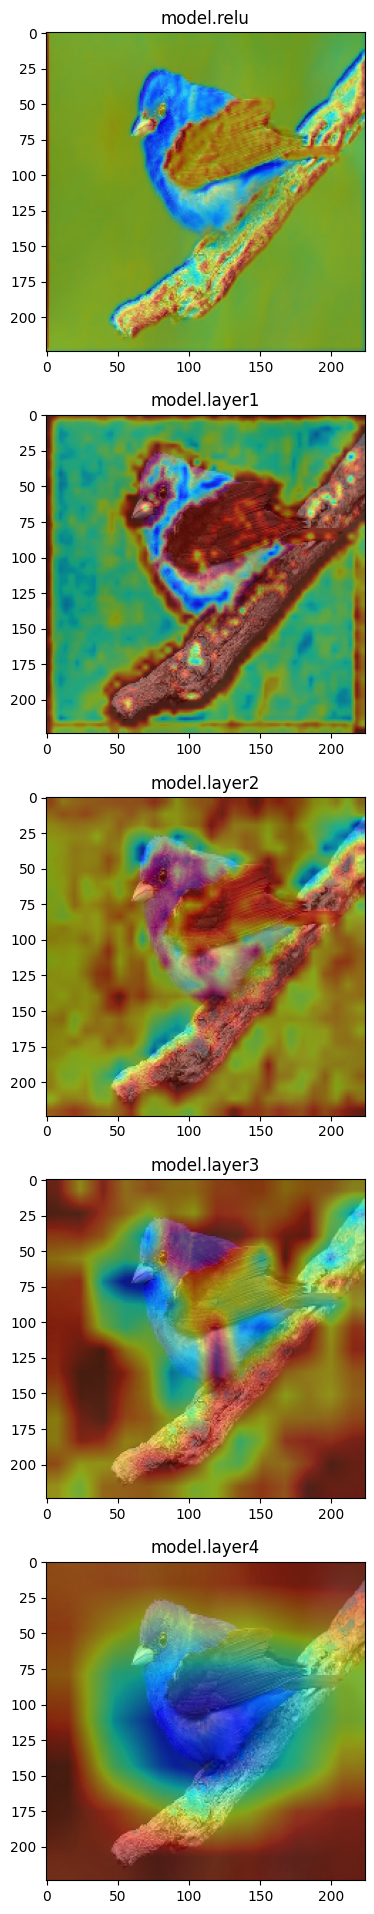

In [14]:
from explainable_cnn import CNNExplainer

classes_name = {
                0: 0, # "airplane"
                1: 1, # "automobile"
                2: 2, # "bird"
                3: 3, # "cat"
                4: 4, # "deer"
                5: 5,  # "dog"
                6: 6, # "frog"
                7: 7, # "horse"
                8: 8, # "ship"
                9: 9 # "truck"
}
layers = ["model.relu", "model.layer1", "model.layer2", "model.layer3", "model.layer4"]
x_cnn = CNNExplainer(model_1, classes_name)

# Pick a picture of your choice and Run the following code with your trained model_1

grad_cam = x_cnn.get_grad_cam(
    './bird.jpg', # replace with your image path
    2, # replace with your image label
    (224, 224),
    layers
)

fig, axs = plt.subplots(len(layers), figsize=(10, 24))
# Note that get_grad_cam() returns list of images (numpy array)
for i in range(0, len(layers)):
  axs[i].set_title(layers[i])
  axs[i].imshow(grad_cam[i].astype('uint8'))

#### Explain about one advantage and one limitation of using Grad-CAM (Gradient-weighted Class Activation Mapping) as a method for explaining the predictions of Convolutional Neural Networks (CNNs) (15 point)

# Answer</br>
- Advantage of using Grad-CAM:

It is easy to implement and can be used with a variety of CNN architectures. It only requires access to the gradients of the model's output with respect to the input image. This makes it good for visualizing the explanations of models and can give us insight about what the model does and how does it see the image and which features play a significant role in models final decesion.
- Limitation of using Grad-CAM:

It can sometimes produce heatmaps that do not accurately localize the relevant parts of the input image. Specially for images that contain multiple instances of the same object or class. In these cases, Grad-CAM may focus on an instance of the object that is not the one that the model is actually using to make its prediction.